In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference, blacklists

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

sample_id_to_group_id = {
    "PD50477f": "PD50477f",
    "PD50519d": "PD46180c_PD50519d",
    "PD50508f": "PD50508bf",
    "PD50523b": "PD50523b",
    "PD50521b": "PD50521be",
    "PD50508b": "PD50508bf",
    "PD46180c": "PD46180c_PD50519d",
    "PD50521e": "PD50521be",
    "PD50489e": "PD50489e",
}

group_id_order = [
    "PD46180c_PD50519d",
    "PD50521be",
    "PD50508bf",
    "PD50477f",
    "PD50489e",
    "PD50523b",
]

sample_id_order = [
    "PD46180c", 
    "PD50519d", 
    "PD50508b", 
    "PD50508f", 
    "PD50521b", 
    "PD50521e", 
    "PD50477f", 
    "PD50489e",
    "PD50523b", 
]

# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [6]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 9/9 [00:06<00:00,  1.47it/s]

CPU times: user 63 ms, sys: 83.4 ms, total: 146 ms
Wall time: 6.12 s


## Subset of reads with at least 4 SNPs (only four because we focus on COs)

In [7]:
dense_reads_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        'grch37_chromosome_size_in_bp',
        'high_quality_snp_positions',
        'CO_active_interval_start',
        'CO_active_interval_end',
        'CO_active_interval_length_bp',
        'grch37_reference_start',
        'grch38_reference_start',
        'grch37_reference_end',
        'grch38_reference_end',
        'grch37_reference_start_cM',
        'grch37_reference_end_cM',
        'CO_active_interval_start_cM',
        'CO_active_interval_end_cM',
        'CO_active_interval_crossover_prob',
        'AA_motif_center_pos',
        'AA_heat',
        'AA_motif_strand',
        'CL4_motif_center_pos',
        'CL4_heat',
        'CL4_motif_strand',
        'is_high_quality_read',
        "min_coverage_hap1",
        "min_coverage_hap2",
    )
    .filter(pl.col("high_quality_snp_positions").list.len() >= 4)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
)

## Cross with recombinant reads

In [8]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

very_trusty_cls_df = cls_df.filter(pl.col("high_quality_classification"))


In [9]:
%%time
dense_reads_with_detection_df = (dense_reads_df
    .join(
        very_trusty_cls_df.select("read_name", "class", "snp_positions_on_read", "idx_transitions").lazy(),
        on="read_name",
        how="left",
    )                  
).collect()

CPU times: user 50.7 s, sys: 22 s, total: 1min 12s
Wall time: 1min 14s


# # of events, expected vs. observed

Carefully constrain the set of reads for this analysis:

* Only reads with sufficient coverage, to (over)account for the effect of filtering for coverage between switches
* Only high quality reads
* We can allow 4 SNPs

In [10]:
# The first three conditions are already met, but are written here explicitly
possible_CO_subset_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 4)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .filter(pl.col("min_coverage_hap1") >= 3)
    .filter(pl.col("min_coverage_hap2") >= 3)
)



In [11]:
def get_obs_exp(df):
    n_observed_COs = len(df.filter(pl.col("class") == "CO"))
    
    ps = df["CO_active_interval_crossover_prob"].to_numpy()

    # Expected is \sum_{p}
    mean_expected_COs = ps.sum()

    # Variance is \sum_{p(1-p)}
    std_expected_COs = (ps*(1-ps)).sum()**0.5
    
    return {
        "n_observed_COs": n_observed_COs,
        "mean_expected_COs": mean_expected_COs,
        "std_expected_COs": std_expected_COs,
    }
    
    

In [12]:
get_obs_exp(possible_CO_subset_df)

{'n_observed_COs': 1383,
 'mean_expected_COs': 1245.940666859975,
 'std_expected_COs': 35.27832608094175}

In [13]:
for i, sample_id in enumerate(sample_id_order):
    d = get_obs_exp(possible_CO_subset_df.filter(pl.col("sample_id") == sample_id))
    print(d, d["std_expected_COs"]**2)


{'n_observed_COs': 232, 'mean_expected_COs': 211.0012683124151, 'std_expected_COs': 14.51757482944802} 210.7599789286227
{'n_observed_COs': 136, 'mean_expected_COs': 119.99521497516533, 'std_expected_COs': 10.948474517699648} 119.86909426471853
{'n_observed_COs': 121, 'mean_expected_COs': 118.67322534777362, 'std_expected_COs': 10.887275016591692} 118.53275728690163
{'n_observed_COs': 77, 'mean_expected_COs': 76.32569907838102, 'std_expected_COs': 8.730880702899887} 76.22827784826961
{'n_observed_COs': 212, 'mean_expected_COs': 208.32022655531526, 'std_expected_COs': 14.425418557203287} 208.09270055050496
{'n_observed_COs': 154, 'mean_expected_COs': 118.46850607706362, 'std_expected_COs': 10.878944088426115} 118.35142447910151
{'n_observed_COs': 170, 'mean_expected_COs': 138.79962210026736, 'std_expected_COs': 11.775172289173232} 138.65468243971318
{'n_observed_COs': 116, 'mean_expected_COs': 102.32494007210374, 'std_expected_COs': 10.109925071143628} 102.2105849441385
{'n_observed_COs

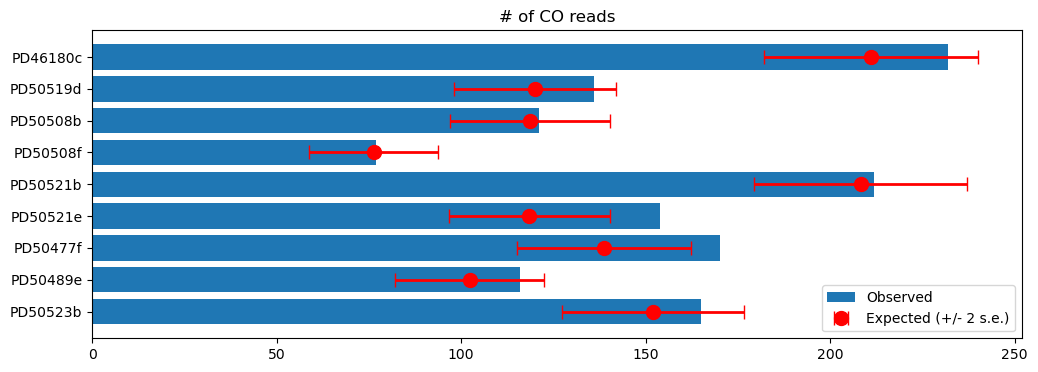

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))

for i, sample_id in enumerate(sample_id_order):
    d = get_obs_exp(possible_CO_subset_df.filter(pl.col("sample_id") == sample_id))
    
    ax.barh(
        y = i,
        width = d["n_observed_COs"],
        color = "C0",        
    );
    
    ax.errorbar(
        x = d["mean_expected_COs"],
        y = i,
        xerr = d["std_expected_COs"] * 2,
        color = "red",
        ms = 10,
        fmt='o',
        elinewidth = 2,
        capsize = 5,
    );
    
ax.invert_yaxis()
ax.set_yticks(np.arange(len(sample_id_order)), sample_id_order);
ax.legend(["Observed", "Expected (+/- 2 s.e.)"]);
ax.set_title("# of CO reads");
    

# Overall rates

## cM/Mb rates

In [15]:
CO_df = (dense_reads_with_detection_df
    .filter(pl.col("class") == "CO")
    .with_columns(
        grch37_active_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_active_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_active_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_active_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
    )
    .with_columns(
        grch37_active_region_length = pl.col("grch37_active_end_pos") - pl.col("grch37_active_start_pos"),                
        grch38_active_region_length = pl.col("grch38_active_end_pos") - pl.col("grch38_active_start_pos"),                
    )
)

dfs = []
for [chrom], df in CO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_active_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_active_start_pos"]) * 1e2,
            grch37_active_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_active_end_pos"]) * 1e2,
        ).with_columns(
            grch37_active_cM = (pl.col("grch37_active_end_poses_cm") - pl.col("grch37_active_start_poses_cm")),
            grch37_cM_per_bp_across_active = (pl.col("grch37_active_end_poses_cm") - pl.col("grch37_active_start_poses_cm")) / pl.col("grch37_active_region_length"),
        )
    )
    
CO_df = pl.concat(dfs)

### cM/Mb across CO interval

In [16]:
(CO_df["grch37_cM_per_bp_across_active"]*1e6).mean()

33.51887504776571

### Compare to background

In [17]:
(dense_reads_with_detection_df
    .select(pl.col("CO_active_interval_crossover_prob")*1e2 / pl.col("CO_active_interval_length_bp") * 1e6)
).mean()

CO_active_interval_crossover_prob
f64
1.179698


# Compare CO distribution between samples

In [18]:
sample_id_to_active_interval_lengths = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter((pl.col("sample_id") == sample_id) & (pl.col("class") == "CO"))
    )
    lens = sdf["CO_active_interval_crossover_prob"] * 1e2
    
    sample_id_to_active_interval_lengths[sample_id] = lens.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    lens_1 = sample_id_to_active_interval_lengths[sample_id1]
    lens_2 = sample_id_to_active_interval_lengths[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(lens_1), 
            len(lens_2),
            scipy.stats.ks_2samp(lens_1, lens_2).pvalue,
            inference.permutation_testing([[lens_1, lens_2]], 1000),
        ]
    )
    
pairwise_co_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "lens_ks_pvalue", 
            "lens_AD_perm_pvalue", ],
)    

100%|██████████| 36/36 [00:07<00:00,  4.96it/s]


In [19]:
pairwise_co_df.sort("lens_AD_perm_pvalue")

sample_id1,sample_id2,n1,n2,lens_ks_pvalue,lens_AD_perm_pvalue
str,str,i64,i64,f64,f64
"""PD46180c""","""PD50523b""",251,192,8.2029e-8,0.0
"""PD50477f""","""PD50523b""",190,192,2.7814e-7,0.0
"""PD50489e""","""PD50523b""",165,192,0.000002,0.0
"""PD50508b""","""PD50521e""",155,185,0.002072,0.0
"""PD50508b""","""PD50523b""",155,192,1.2882e-7,0.0
"""PD50508f""","""PD50523b""",119,192,8.7544e-7,0.0
"""PD50519d""","""PD50523b""",163,192,0.000015,0.0
"""PD50521b""","""PD50523b""",226,192,0.000002,0.0
"""PD50521e""","""PD50523b""",185,192,0.00874,0.003


## Group level; take PD50523b out to see signal beyond that

In [20]:
group_id_to_active_interval_lengths = {}

for group_id in group_id_order:
    group_id_to_active_interval_lengths[group_id] = np.concatenate([
        sample_id_to_active_interval_lengths[sample_id]
        for sample_id, v in sample_id_to_group_id.items() if v == group_id
    ])

In [21]:
rows = []
for group_id in tqdm.tqdm(sorted(group_id_order)):
    pairs = [
        [
            group_id_to_active_interval_lengths[group_id],
            group_id_to_active_interval_lengths[other_group_id],
        ]
        for other_group_id in group_id_order if other_group_id != group_id and other_group_id != "PD50523b"
    ]
    lens_1 = group_id_to_active_interval_lengths[group_id]
    rows.append(
        [
            group_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
group_vs_rest_df = pl.DataFrame(
    rows,
    schema=["group_id", "n_in_group", "AD_perm_pvalue"],
)

100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


In [22]:
group_vs_rest_df

group_id,n_in_group,AD_perm_pvalue
str,i64,f64
"""PD46180c_PD50519d""",414,0.155
"""PD50477f""",190,0.168
"""PD50489e""",165,0.163
"""PD50508bf""",274,0.0
"""PD50521be""",411,0.002
"""PD50523b""",192,0.0


## Present this as a matrix

In [23]:
mat = []
for sample_id1 in sample_id_order:
    row = []
    for sample_id2 in sample_id_order:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_co_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["lens_AD_perm_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
mat = pd.DataFrame(mat, index=sample_id_order, columns=sample_id_order)

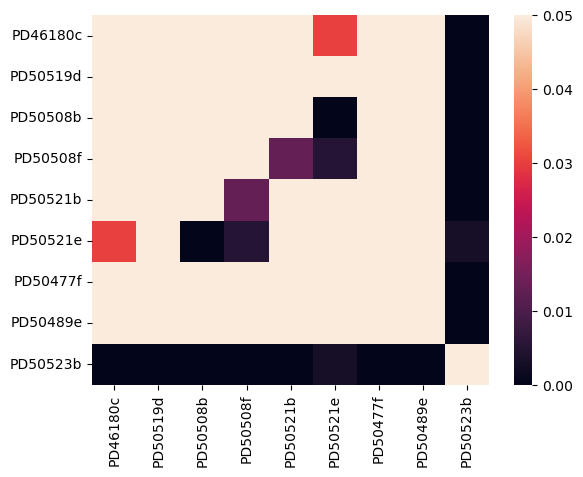

In [24]:
sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
);

## Again, but now unifying samples

In [25]:
group_id_to_active_interval_lengths = {}

for group_id in group_id_order:
    group_id_to_active_interval_lengths[group_id] = np.concatenate([
        sample_id_to_active_interval_lengths[sample_id]
        for sample_id, v in sample_id_to_group_id.items() if v == group_id
    ])

In [26]:
rows = []
for group_id1, group_id2 in tqdm.tqdm(list(itertools.combinations(group_id_order, 2))):
    lens_1 = group_id_to_active_interval_lengths[group_id1]
    lens_2 = group_id_to_active_interval_lengths[group_id2]
    rows.append(
        [
            group_id1, 
            group_id2,
            len(lens_1), 
            len(lens_2),
            scipy.stats.ks_2samp(lens_1, lens_2).pvalue,
            inference.permutation_testing([[lens_1, lens_2]], 1000),
        ]
    )
    
groupwise_co_df = pl.DataFrame(
    rows,
    schema=["group_id1", "group_id2", "n1", "n2", 
            "lens_ks_pvalue", 
            "lens_AD_perm_pvalue", ],
)    

100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


In [27]:
groupwise_co_df.sort("lens_AD_perm_pvalue")

group_id1,group_id2,n1,n2,lens_ks_pvalue,lens_AD_perm_pvalue
str,str,i64,i64,f64,f64
"""PD46180c_PD50519d""","""PD50523b""",414,192,1.1384e-8,0.0
"""PD50521be""","""PD50508bf""",411,274,0.00875,0.0
"""PD50521be""","""PD50523b""",411,192,0.000011,0.0
"""PD50508bf""","""PD50523b""",274,192,1.6356e-9,0.0
"""PD50477f""","""PD50523b""",190,192,2.7814e-7,0.0
"""PD50489e""","""PD50523b""",165,192,0.000002,0.0
"""PD50508bf""","""PD50489e""",274,165,0.014841,0.026
"""PD46180c_PD50519d""","""PD50508bf""",414,274,0.089445,0.053
"""PD50521be""","""PD50477f""",411,190,0.055553,0.114


### Present this as a matrix

In [28]:
mat = []
for group_id1 in group_id_order:
    row = []
    for group_id2 in group_id_order:
        if group_id1 == group_id2:
            pval = 1
        else:
            pval = groupwise_co_df.filter(
                ((pl.col("group_id1") == group_id1) & (pl.col("group_id2") == group_id2)) | 
                ((pl.col("group_id1") == group_id2) & (pl.col("group_id2") == group_id1))
            )["lens_AD_perm_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
mat = pd.DataFrame(mat, index=group_id_order, columns=group_id_order)

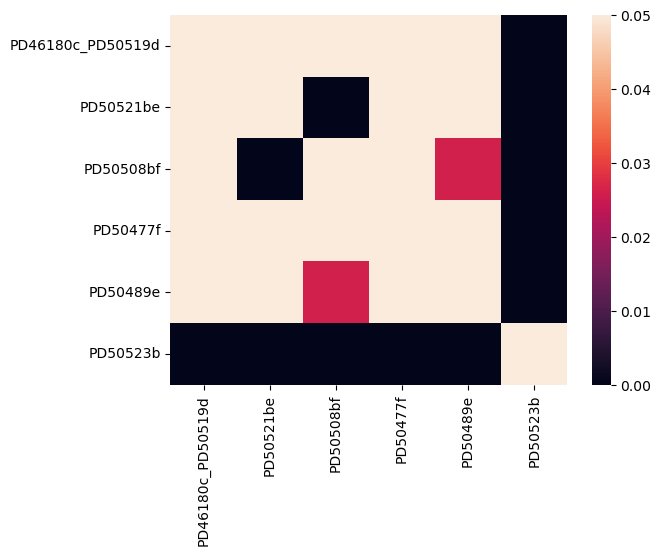

In [29]:
sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
);

# Test one sample vs the rest

## Sample level (exclude "PD50523b" because it's too different)

In [30]:
rows = []
for sample_id in tqdm.tqdm(sorted(sample_ids)):
    pairs = [
        [
            sample_id_to_active_interval_lengths[sample_id],
            sample_id_to_active_interval_lengths[other_sample_id],
        ]
        for other_sample_id in sample_ids if other_sample_id != sample_id and other_sample_id != "PD50523b"
    ]
    lens_1 = sample_id_to_active_interval_lengths[sample_id]
    rows.append(
        [
            sample_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
sample_vs_rest_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_in_sample", "AD_perm_pvalue"],
)

100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


In [31]:
sample_vs_rest_df.sort("AD_perm_pvalue")

sample_id,n_in_sample,AD_perm_pvalue
str,i64,f64
"""PD50508f""",119,0.0
"""PD50521e""",185,0.0
"""PD50523b""",192,0.0
"""PD50508b""",155,0.001
"""PD50521b""",226,0.086
"""PD46180c""",251,0.136
"""PD50477f""",190,0.138
"""PD50489e""",165,0.174
"""PD50519d""",163,0.293


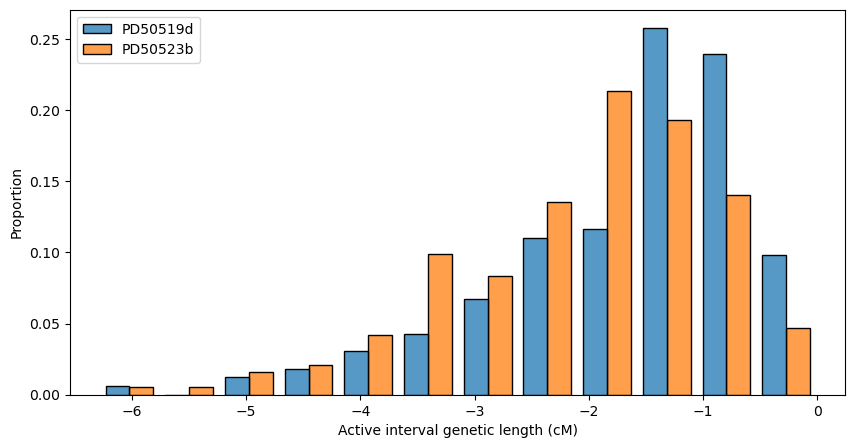

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

sample_id1 = "PD50519d"
sample_id2 = "PD50523b"

sns.histplot(
    [
        pd.Series(np.log10(sample_id_to_active_interval_lengths[sample_id1]), name=sample_id1),
        pd.Series(np.log10(sample_id_to_active_interval_lengths[sample_id2]), name=sample_id2),
    ], 
    bins=12, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length (cM)");


## Group level; take PD50523b out to see signal beyond that

In [33]:
rows = []
for group_id in tqdm.tqdm(sorted(group_id_order)):
    pairs = [
        [
            group_id_to_active_interval_lengths[group_id],
            group_id_to_active_interval_lengths[other_group_id],
        ]
        for other_group_id in group_id_order if other_group_id != group_id and other_group_id != "PD50523b"
    ]
    lens_1 = group_id_to_active_interval_lengths[group_id]
    rows.append(
        [
            group_id, 
            len(lens_1), 
            inference.permutation_testing(pairs, 1000),
        ]
    )
    
group_vs_rest_df = pl.DataFrame(
    rows,
    schema=["group_id", "n_in_group", "AD_perm_pvalue"],
)

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


In [34]:
group_vs_rest_df

group_id,n_in_group,AD_perm_pvalue
str,i64,f64
"""PD46180c_PD50519d""",414,0.155
"""PD50477f""",190,0.168
"""PD50489e""",165,0.163
"""PD50508bf""",274,0.0
"""PD50521be""",411,0.002
"""PD50523b""",192,0.0


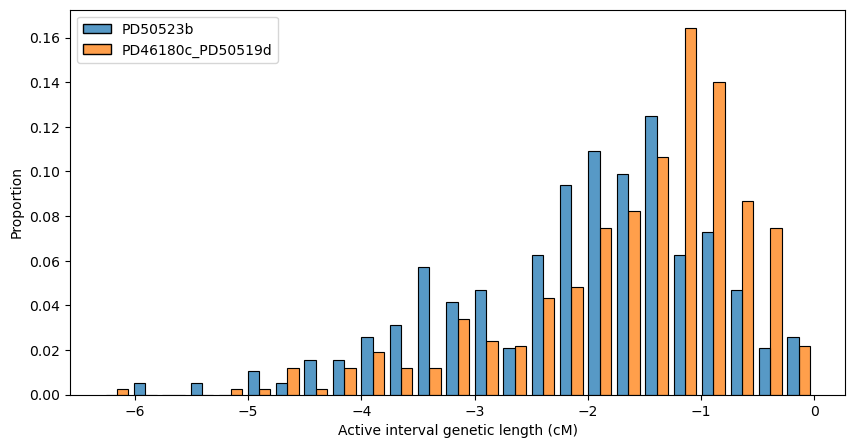

In [35]:
fig, ax = plt.subplots(figsize=(10,5))

group_id1 = "PD50523b"
group_id2 = "PD46180c_PD50519d"

sns.histplot(
    [
        pd.Series(np.log10(group_id_to_active_interval_lengths[group_id1]), name=group_id1),
        pd.Series(np.log10(group_id_to_active_interval_lengths[group_id2]), name=group_id2),
    ], 
    bins=25, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length (cM)");


# Pretty plot for differences

In [36]:
%config InlineBackend.figure_format='png'


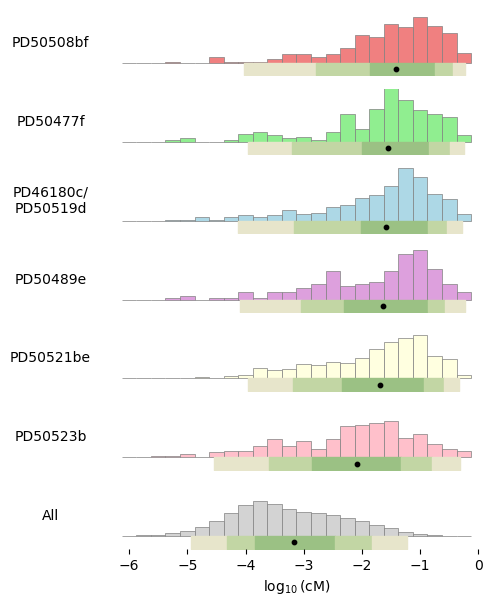

In [37]:
plt.rcParams['font.family'] = 'sans-serif'

fig, axs = plt.subplots(
    nrows=len(group_id_order)+1, 
    ncols=2, 
    figsize=(6, 7),
    width_ratios=[1,10],
)
bins = np.linspace(-6, 0, 25)

colors = [
    "lightcoral",
    "lightgreen",
    "lightblue",
    "plum",
    "lightyellow",
    "pink",
    "lightgrey",
]

darkgreen = '#9BC184'
midgreen = '#C2D6A4'
lightgreen = '#E7E5CB'
quantile_colors = [lightgreen, midgreen, darkgreen, midgreen, lightgreen]

D = group_id_to_active_interval_lengths.copy()
D["All"] = (dense_reads_with_detection_df["CO_active_interval_crossover_prob"]*1e2)[::100]

presentation_order = [
 'PD50508bf',
 'PD50477f',
 'PD46180c_PD50519d',
 'PD50489e',
 'PD50521be',
 'PD50523b',
 'All',
]

for i, k in enumerate(presentation_order):
    v = D[k]
    label = k.replace("_", "/\n")
    
    ax = axs[i,0]
    ax.axis("off");
    ax.set_xlim(0,1);
    ax.set_ylim(0,1);
    ax.text(0.7, 0.5, label, horizontalalignment='center',
        verticalalignment='center')    
    
    ax = axs[i,1]
    H = np.histogram(np.log10(v), bins=bins)[0]
    H = H/H.sum()
    ax.bar(
        x=bins[:-1], 
        height=H, 
        width=bins[1]-bins[0],
        color=colors[i], #"lightgrey",
        edgecolor="grey",
        linewidth=0.5,
    );
    ax.set_ylim(-0.04, 0.17);
    
    if i != len(D)-1:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.set_xticks([])
    else:
        ax.set_xlabel("$\log_{10}$(cM)")
    
    ax.yaxis.set_tick_params(labelleft=False)    
    ax.set_yticks([])

    ax.spines[['bottom', 'right', 'top', 'left']].set_visible(False)
    
    # compute quantiles
    quantiles = np.percentile(np.log10(v), [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        ax.fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            -0.04, # max y=0
            0, # max y=0.0002
            color=quantile_colors[j]
        )
        
    # mean
    ax.scatter([np.log10(v).mean()], [-0.02], color='black', s=10)
    
#fig.subplots_adjust(hspace=0.1)

# DSBs

## Overall rates

### A/A

In [63]:
print("Fraction of CO reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())
    .filter(pl.col("class") == "CO")
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of CO reads with motif in them: 0.6875768757687577


In [64]:
print("Fraction of all reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                    
    .select(pl.col("AA_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of all reads with motif in them: 0.14460322225095426


In [65]:
print("Fraction of CO reads with motif in active region:", (CO_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                            
    .select(
        (pl.col("grch38_active_start_pos") <= pl.col("AA_motif_center_pos")) &
        (pl.col("grch38_active_end_pos") > pl.col("AA_motif_center_pos"))
    )
    .mean().item(0,0)
))

Fraction of CO reads with motif in active region: 0.5456171735241503


### C/L4

In [66]:
print("Fraction of CO reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                   
    .filter(pl.col("class") == "CO")
    .select(pl.col("CL4_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of CO reads with motif in them: 0.1002460024600246


In [67]:
print("Fraction of all reads with motif in them:" ,(dense_reads_with_detection_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                    
    .select(pl.col("CL4_motif_center_pos").is_not_null())
    .mean().item(0,0)
))

Fraction of all reads with motif in them: 0.04143632307879426


In [68]:
print("Fraction of CO reads with motif in active region:", (CO_df
    .filter(pl.col("grch38_reference_start").is_not_null())                                                            
    .select(
        (pl.col("grch38_active_start_pos") <= pl.col("CL4_motif_center_pos")) &
        (pl.col("grch38_active_end_pos") > pl.col("CL4_motif_center_pos"))
    )
    .mean().item(0,0)
))

Fraction of CO reads with motif in active region: 0.17791411042944785


## Overall distances to motif center

### A/A

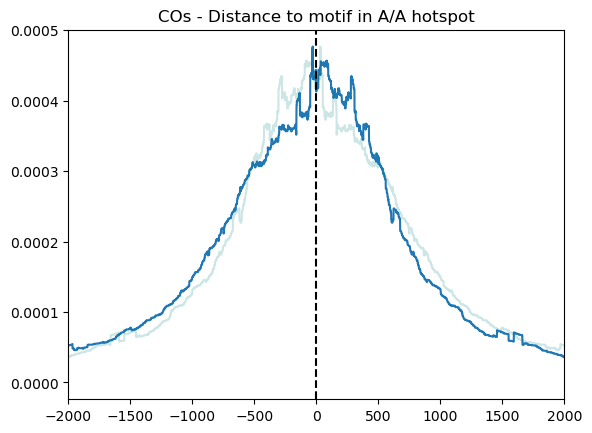

In [44]:
xs, H = inference.calculate_motif_distance_histogram(
    (CO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

plt.plot(xs, H);
plt.plot(xs, H[::-1], color="teal", alpha=0.2);

plt.title("COs - Distance to motif in A/A hotspot");
plt.xlim(-2000,2000);
plt.axvline(0, color="black", ls="--");

In [45]:
inference.motif_distance_histogram_symmetry_permutation_testing(
    (CO_df
        .filter(pl.col("AA_motif_center_pos").is_not_null())
    ),
    "AA_motif_center_pos",
    "AA_motif_strand",
)

0.457

## Distance to motif centers, per sample

 89%|████████▉ | 8/9 [00:13<00:01,  1.66s/it]


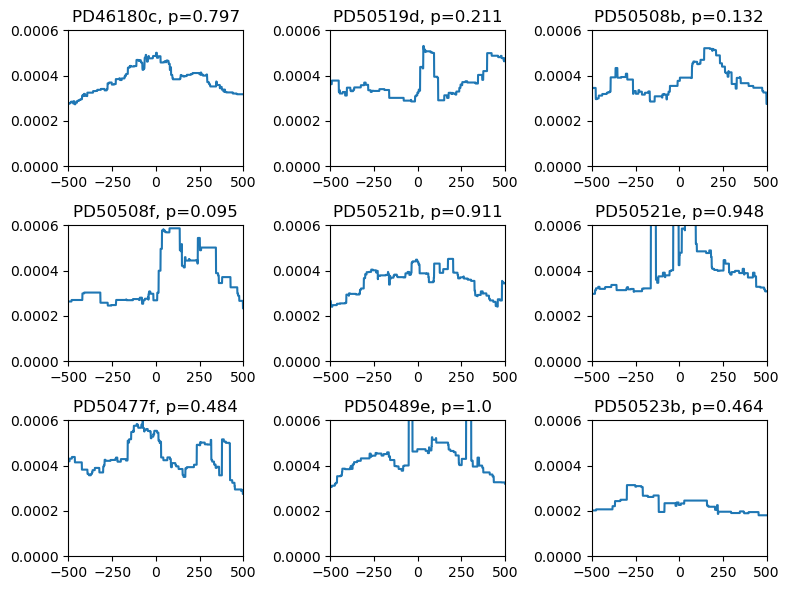

In [46]:
fig, axs = plt.subplots(3, 3, figsize=(8, 6))

motif_distances_per_sample_id = {}

for ax, sample_id in zip(axs.ravel(), tqdm.tqdm(sample_id_order)):
    xs, H = inference.calculate_motif_distance_histogram(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id)
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    pval = inference.motif_distance_histogram_symmetry_permutation_testing(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter(pl.col("sample_id") == sample_id) 
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
    )
    
    motif_distances_per_sample_id[sample_id] = H

    ax.plot(xs, H, label=sample_id);
    ax.set_title(f"{sample_id}, p={pval}")
    ax.set_xlim(-500,500)
    ax.set_ylim(0, 0.0006);

fig.tight_layout()

# Compare distance to motif between samples, in COs

In [47]:
rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    pval = inference.motif_distance_histogram_diffs_permutation_testing(
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id1) & (pl.col("class") == "CO"))
        ),
        (CO_df
            .filter(pl.col("AA_motif_center_pos").is_not_null())
            .filter((pl.col("sample_id") == sample_id2) & (pl.col("class") == "CO"))
        ),
        "AA_motif_center_pos",
        "AA_motif_strand",
        max_dist=30000,
        n_perms=1000,
        stat="sum_abs",
    )
    
    rows.append(
        [
            sample_id1, 
            sample_id2,
            pval,
        ]
    )
    
pairwise_motif_dists_co_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "perm_pval"
           ],
)       

100%|██████████| 36/36 [01:51<00:00,  3.09s/it]


In [48]:
pairwise_motif_dists_co_df.sort("perm_pval")

sample_id1,sample_id2,perm_pval
str,str,f64
"""PD46180c""","""PD50523b""",0.0
"""PD50477f""","""PD50523b""",0.0
"""PD50489e""","""PD50523b""",0.0
"""PD50519d""","""PD50523b""",0.001
"""PD50521e""","""PD50523b""",0.001
"""PD50489e""","""PD50521b""",0.013
"""PD50508f""","""PD50519d""",0.022
"""PD50508b""","""PD50523b""",0.027
"""PD50477f""","""PD50521e""",0.057


# Compare DSB signal strengths between COs

In [69]:
sample_id_to_AA_heats = {}

for sample_id in sample_ids:
    sdf = (dense_reads_with_detection_df
        .filter(pl.col("grch38_reference_start").is_not_null())           
        .filter((pl.col("sample_id") == sample_id) & (pl.col("class") == "CO"))
    )
    heats = sdf["AA_heat"].fill_null(0)
    sample_id_to_AA_heats[sample_id] = heats.to_numpy()

rows = []
for sample_id1, sample_id2 in tqdm.tqdm(list(itertools.combinations(sorted(sample_ids), 2))):
    heats_1 = sample_id_to_AA_heats[sample_id1]
    heats_2 = sample_id_to_AA_heats[sample_id2]
    rows.append(
        [
            sample_id1, 
            sample_id2,
            len(heats_1), 
            len(heats_2),
            scipy.stats.ks_2samp(heats_1, heats_2).pvalue,
            inference.permutation_testing([[heats_1, heats_2]], 1000),
            inference.permutation_testing([[heats_1[heats_1>0], heats_2[heats_2>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_1==0).sum(), (heats_1!=0).sum()],
                 [(heats_2==0).sum(), (heats_2!=0).sum()]],
            ).pvalue,
        ]
    )
    
pairwise_AA_heats_co_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "n1", "n2", 
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

100%|██████████| 36/36 [00:14<00:00,  2.57it/s]


In [70]:
pairwise_AA_heats_co_df.sort("heats_AD_perm_pvalue")

sample_id1,sample_id2,n1,n2,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,str,i64,i64,f64,f64,f64,f64
"""PD46180c""","""PD50523b""",250,190,2.2524e-14,0.0,0.023,1.5304e-12
"""PD50477f""","""PD50523b""",186,190,6.4952e-10,0.0,0.093,1.2180e-8
"""PD50489e""","""PD50523b""",163,190,0.000002,0.0,0.011,0.000265
"""PD50508b""","""PD50523b""",152,190,3.1512e-11,0.0,0.328,2.1852e-12
"""PD50508f""","""PD50523b""",117,190,1.2217e-7,0.0,0.05,0.000002
"""PD50519d""","""PD50523b""",162,190,2.0344e-9,0.0,0.09,5.1906e-8
"""PD50521b""","""PD50523b""",223,190,4.7839e-8,0.0,0.004,0.000002
"""PD50521e""","""PD50523b""",183,190,0.000024,0.0,0.058,0.000265
"""PD46180c""","""PD50521e""",250,183,0.011997,0.008,0.318,0.002394


## Matrix

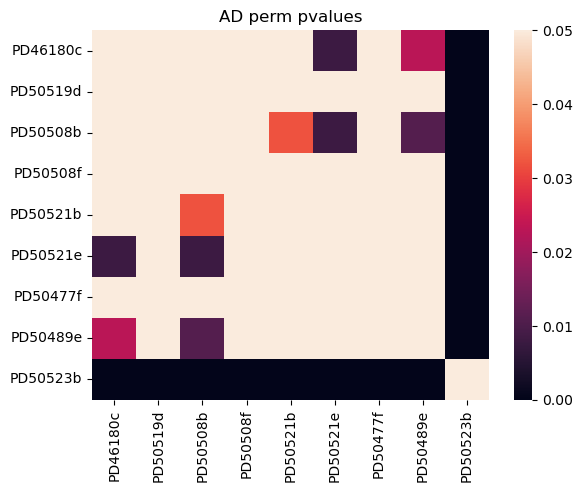

In [71]:
mat = []
for sample_id1 in sample_id_order:
    row = []
    for sample_id2 in sample_id_order:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_AA_heats_co_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["heats_AD_perm_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
mat = pd.DataFrame(mat, index=sample_id_order, columns=sample_id_order)

sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
);

plt.title("AD perm pvalues");

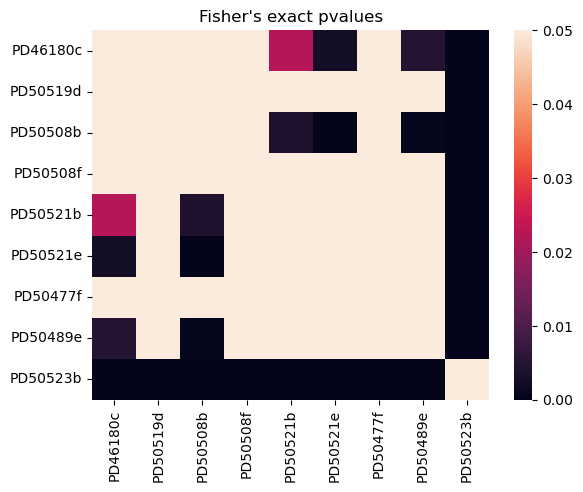

In [72]:
mat = []
for sample_id1 in sample_id_order:
    row = []
    for sample_id2 in sample_id_order:
        if sample_id1 == sample_id2:
            pval = 1
        else:
            pval = pairwise_AA_heats_co_df.filter(
                ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
                ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
            )["heats_fisher_pvalue"].item(0)
        row.append(pval)
    mat.append(row)
    
mat = pd.DataFrame(mat, index=sample_id_order, columns=sample_id_order)

sns.heatmap(
    mat,
    vmin=0, 
    vmax=0.05,
);

plt.title("Fisher's exact pvalues");

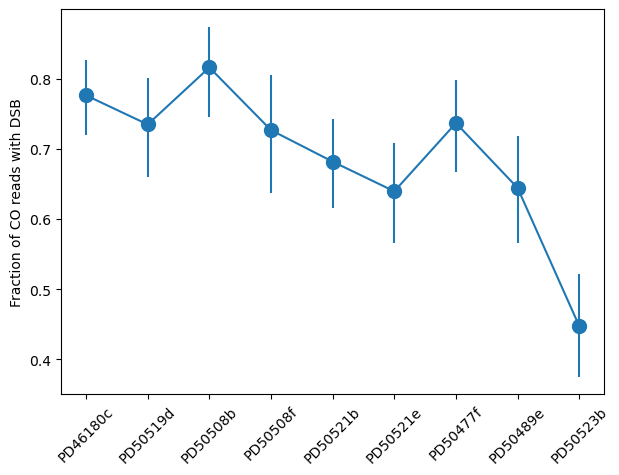

In [73]:
fig, ax = plt.subplots(figsize=(7,5))

mns = [(sample_id_to_AA_heats[s]>0).mean() for s in sample_id_order]
cis = [statsmodels.stats.proportion.proportion_confint(
    (sample_id_to_AA_heats[s]>0).sum(),
    len(sample_id_to_AA_heats[s]),
    method="beta",
) for s in sample_id_order]
    


ax.errorbar(
    x = np.arange(len(sample_id_order)),
    y = mns,
    yerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis, mns)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis, mns)],
    ],
    fmt=".-",
    ms=20,
    
);
ax.set_xticks(ticks = np.arange(len(sample_id_order)), labels=sample_id_order, rotation=45);
ax.set_ylabel("Fraction of CO reads with DSB");

## Look at some examples

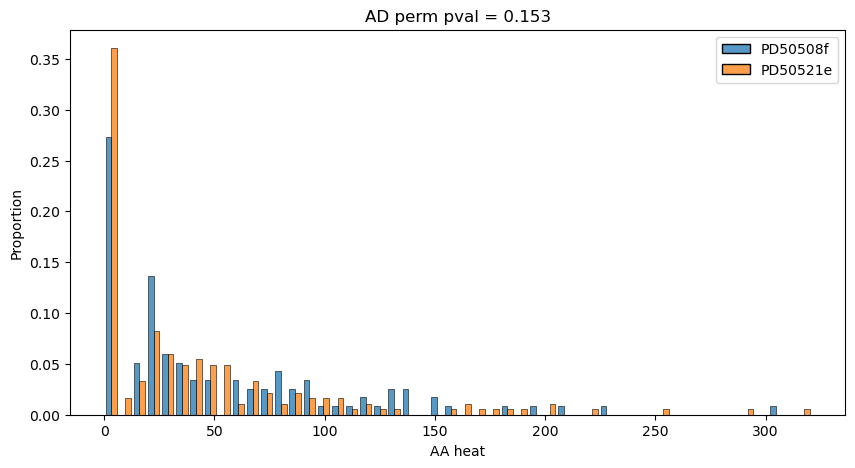

In [74]:
fig, ax = plt.subplots(figsize=(10,5))

sample_id1 = "PD50508f"
sample_id2 = "PD50521e"

pval = pairwise_AA_heats_co_df.filter(
    ((pl.col("sample_id1") == sample_id1) & (pl.col("sample_id2") == sample_id2)) | 
    ((pl.col("sample_id1") == sample_id2) & (pl.col("sample_id2") == sample_id1))
)["heats_AD_perm_pvalue"].item(0)

sns.histplot(
    [
        pd.Series(sample_id_to_AA_heats[sample_id1], name=sample_id1),
        pd.Series(sample_id_to_AA_heats[sample_id2], name=sample_id2),
    ], 
    bins=50, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("AA heat");
plt.title(f"AD perm pval = {pval}");


# Distance to telomeres

$Pr(dist|detected) \propto Pr(detected|dist)Pr(dist)$

$Pr(dist) \approx $ (num of reads in dist)/(num total reads) \propto (num of reads in dist)

$Pr(detected|dist) \approx \frac{1}{\text{num of reads in dist}}\sum_{read\ in\ dist}{Pr(detected|read)}$ \Rightarrow

$Pr(dist|detected) \propto \sum_{read\ in\ dist}{Pr(detected|read)}$ (???)

In [56]:
dense_reads_with_detection_df.columns

['read_name',
 'read_length',
 'chrom',
 'sample_id',
 'grch37_chromosome_size_in_bp',
 'high_quality_snp_positions',
 'CO_active_interval_start',
 'CO_active_interval_end',
 'CO_active_interval_length_bp',
 'grch37_reference_start',
 'grch38_reference_start',
 'grch37_reference_end',
 'grch38_reference_end',
 'grch37_reference_start_cM',
 'grch37_reference_end_cM',
 'CO_active_interval_start_cM',
 'CO_active_interval_end_cM',
 'CO_active_interval_crossover_prob',
 'AA_motif_center_pos',
 'AA_heat',
 'AA_motif_strand',
 'CL4_motif_center_pos',
 'CL4_heat',
 'CL4_motif_strand',
 'is_high_quality_read',
 'min_coverage_hap1',
 'min_coverage_hap2',
 'class',
 'snp_positions_on_read',
 'idx_transitions']

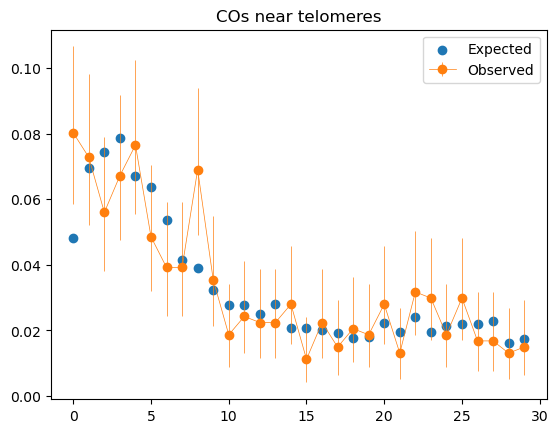

In [57]:
exp_df = (dense_reads_with_detection_df
    .filter(pl.col("grch37_reference_start") < 30e6)
    .with_columns(
        rounded_grch37_reference_start = (pl.col("grch37_reference_start") // (1e6)).cast(pl.Int64),
    )
    .group_by("rounded_grch37_reference_start")
    .agg(pl.col("CO_active_interval_crossover_prob").sum().alias("exp"))
    .sort("rounded_grch37_reference_start")
    .with_columns(
        exp = pl.col("exp") / pl.col("exp").sum()
    )
)

obs_df = (CO_df
    .filter(pl.col("grch37_reference_start") < 30e6)
    .with_columns(
        rounded_grch37_reference_start = (pl.col("grch37_reference_start") // (1e6)).cast(pl.Int64),
    )
    .group_by("rounded_grch37_reference_start")
    .len()
    .sort("rounded_grch37_reference_start")
    .with_columns(
        obs = pl.col("len") / pl.col("len").sum()
    )
)

n_total = len(CO_df
    .filter(pl.col("grch37_reference_start") < 30e6)
)

low_ci, high_ci = statsmodels.stats.proportion.proportion_confint(
    obs_df["len"], n_total, alpha=0.05, method='beta'
)

plt.scatter(
    exp_df["rounded_grch37_reference_start"],
    exp_df["exp"],
    label="Expected",
)

plt.errorbar(
    x=obs_df["rounded_grch37_reference_start"],
    y=obs_df["obs"],
    yerr=[obs_df["obs"]-low_ci, high_ci-obs_df["obs"]],
    color="C1",
    label="Observed",
    fmt='-o',
    lw=0.5,
)

plt.legend();
plt.title("COs near telomeres");

In [58]:
basic_filtering_no_common_transition = \
    (pl.col("min_coverage_between_transitions_hap1") >= 3) & \
    (pl.col("min_coverage_between_transitions_hap2") >= 3) & \
    (pl.col("mapq1") >= 60) & \
    (pl.col("mapq2") >= 60) & \
    (pl.col("is_forward1") == pl.col("is_forward2"))

extra_filtering = \
    (pl.col("total_mismatches") <= 100) & \
    (pl.col("total_clipping") <= 10) & \
    (~pl.col("read_name").is_in(blacklists.NCO_read_blacklist))

# Is it justified to filter reads with common transitions? (Mostly yes)

In [59]:
reads_with_common_df = dense_reads_with_detection_df.join(
    cls_df.filter(basic_filtering_no_common_transition & extra_filtering & pl.col("has_common_transition")).select("read_name"),
    on="read_name",
)

reads_without_common_df = dense_reads_with_detection_df.join(
    cls_df.filter(basic_filtering_no_common_transition & extra_filtering & ~pl.col("has_common_transition")).select("read_name"),
    on="read_name",
)

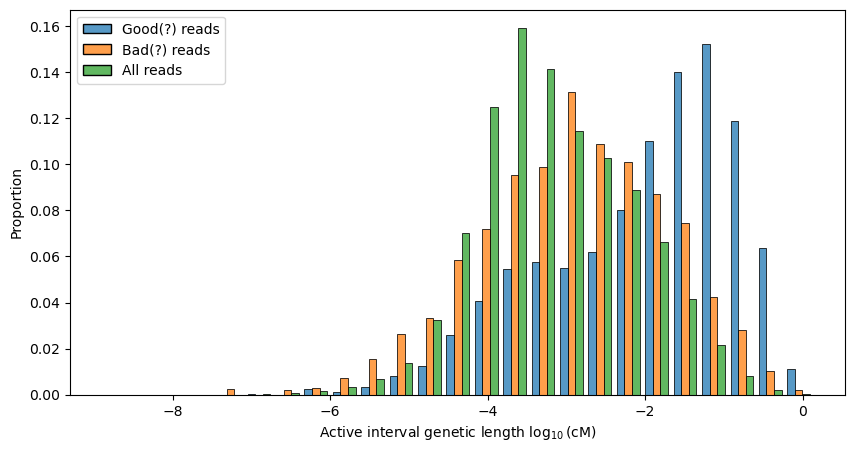

In [60]:
fig, ax = plt.subplots(figsize=(10,5))

reads_without_common_interval_lengths = reads_without_common_df["CO_active_interval_crossover_prob"] * 1e2
reads_with_common_interval_lengths = reads_with_common_df["CO_active_interval_crossover_prob"] * 1e2
background_interval_lengths = dense_reads_with_detection_df.sample(fraction=1e-2)["CO_active_interval_crossover_prob"] * 1e2

sns.histplot(
    [
        pd.Series(np.log10(reads_without_common_interval_lengths), name="Good(?) reads"),
        pd.Series(np.log10(reads_with_common_interval_lengths), name="Bad(?) reads"),
        pd.Series(np.log10(background_interval_lengths), name="All reads"),
    ], 
    bins=25, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length $\log_{10}$(cM)");
